<a href="https://colab.research.google.com/github/syusuke9999/Home-made-Neural-Network/blob/main/%E8%87%AA%E4%BD%9C%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **csvファイルを読み込む**

In [ ]:
csv_data = pd.read_csv("day.csv")

### **訓練用データとして、最初から１つずつ飛ばして取得する**


In [ ]:
csv_training = csv_data[0:731:2]

### **検証用データとして、２番目から１つずつ飛ばして取得する**

In [ ]:
csv_valid    = csv_data[1:731:2]

## **データの下準備**

#### **説明変数に、季節、曜日、休日・平日、ワーキングデー（休日でも週末でもない）か、天気の状態、気温、体感気温、湿度、風の強さを取る**
#### **目的変数に、非会員の利用数、会員の利用数、合計数の3つを全て取って学習に用いる**

#### **季節、曜日、気象状況は、名義尺度であり、お互い比べたり大小を比較したり出来ない（しても意味がない）**
#### **そのため、一旦文字列表記に置き換えた名義尺度を後ほどOne-Hot Encodingする（pandasのダミー変数の機能を使う）**

###  **訓練用データの準備・処理**

In [ ]:
training_data                 = csv_training.loc[:,['season','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']]
training_data['season']       = training_data['season'].map({1: 'spring',2: 'summer',3: 'fall',4:'winter'})
training_data['weekday']      = training_data['weekday'].map({0:'Sun',1: 'Mon',2: 'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})
training_data['weathersit']   = training_data['weathersit'].map({1:'Clear, Few clouds, Partly cloudy, Partly cloudy',2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})
training_data                 = pd.get_dummies(training_data,prefix=['season','weekday','weathersit'], drop_first=False)

### **検証用データの準備・処理**

In [ ]:
vaild_data                    = csv_valid.loc[:,['season','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']]
vaild_data['season']          = vaild_data['season'].map({1: 'spring',2: 'summer',3: 'fall',4:'winter'})
vaild_data['weekday']         = vaild_data['weekday'].map({0:'Sun',1: 'Mon',2: 'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})
vaild_data['weathersit']      = vaild_data['weathersit'].map({1:'Clear, Few clouds, Partly cloudy, Partly cloudy',2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})
vaild_data                    = pd.get_dummies(vaild_data,prefix=['season','weekday','weathersit'], drop_first=False)

#### **教師データであるレンタルバイク数をそのまま扱うと、シグモイド関数がサチュレートしてしまうため、標準偏差１で標準化する。**

In [ ]:
# 後で変換できるように、スケーリングを辞書に保存する
quant_features = ['temp','atemp','hum','windspeed','casual','registered','cnt']
training_scaled_features = {}
for each in quant_features:
    mean, std = training_data[each].mean(), training_data[each].std()
    training_scaled_features[each] = [mean, std]
    training_data.loc[:, each]   = (training_data[each] - mean)/std

In [ ]:
valid_scaled_features = {}
for each in quant_features:
    v_mean, v_std = csv_valid[each].mean(), csv_valid[each].std()
    valid_scaled_features[each] = [v_mean, v_std]
    vaild_data.loc[:, each] = (csv_valid[each] - v_mean)/v_std

### **シグモイド関数の定義**

In [ ]:
@np.vectorize
def Sigmoid(x):
    result = 1.0/(1.0 + np.exp(-x))
    return result

### **二乗和誤差の定義**

In [ ]:
def MSE(t,i):
    return np.mean((t-i)**2)

**ニューラルネットワークへ順伝播して出力を得る**

In [ ]:
def query(inputs_list):
    global w_ih, h_in
    inputs = np.array(inputs_list, ndmin=2).T
    hidden_inputs = np.dot(w_ih, inputs)
    hidden_outputs = Sigmoid(hidden_inputs)
    final_inputs = np.dot(w_ho, hidden_outputs)
    final_outputs = final_inputs
    return final_outputs

### **ニューラルネットワークを訓練する**

In [ ]:
def train(inputs_list, targets_list):
    global w_ih, h_in, h_out, o_in, w_ho, o_out,lr,train_loss,val_loss
    for inputs, targets in zip(inputs_list,targets_list):
        #重み行列と入力、出力の行列同士の内積を計算するため、縦ベクトルとする
        inputs         = np.array(inputs, ndmin=2).T
        targets        = np.array(targets, ndmin=2).T
        h_in           = np.dot(w_ih, inputs)
        h_out          = Sigmoid(h_in)
        f_in           = np.dot(w_ho, h_out)
        f_out          = f_in
        output_error   = f_out - targets
        #中間層へ伝える誤差を計算するため、出力層での誤差を重みに応じて配分する
        h_err          = np.dot(w_ho.T , output_error)
        # 出力層は恒等写像のため、outputerror（誤差項）に出力値-正解をそのまま使う
        w_ho           -= lr * np.dot(output_error, np.transpose(h_out))
        #中間層はシグモイド関数だが、シグモイド関数を微分した関数を使わなくとも、
        #既にシグモイド関数を通って出力された値を、Sigmoid＊(１－Sigmoid)とする事で誤差項を計算できる。
        w_ih           -= lr * np.dot((h_err * h_out * (1.0 - h_out)), np.transpose(inputs))

## **特徴データと教師データに分ける**

In [ ]:
target = ['cnt', 'casual', 'registered']
training_data, training_target = training_data.drop(target, axis=1), training_data[target]
vaild_data = vaild_data.sample(frac=1)
vaild_data, vaild_target = vaild_data.drop(target, axis=1), vaild_data[target]

## **Pandasデータをnumpy形式に変換**

In [ ]:
training_data = training_data.values
training_target = training_target.values
vaild_data = vaild_data.values
vaild_target = vaild_target.values

### **重み行列やその他変数を初期化**

In [ ]:
i_nodes = training_data[0,:].shape[0]
h_nodes = 10
o_nodes = 3
w_ih = np.random.normal(0.0,pow(h_nodes,-0.5),size=(h_nodes,i_nodes))
w_ho = np.random.normal(0.0,pow(o_nodes,-0.5),size=(o_nodes,h_nodes))
h_in = np.zeros([h_nodes])
h_out = np.zeros([h_nodes])
o_in  = np.zeros([o_nodes])
o_out = np.zeros([o_nodes])

### **ハイパーパラメーターを決めて、トレーニング開始**

In [ ]:
import sys
train_loss = np.array(0)
val_loss = np.array(0)
err_t = 0.0
err_v = 0.0
t_loss = 0.0
v_loss = 0.0
lr    = 0.0005
epoch = 50000
for e in range(epoch):
    train(training_data,training_target)
    # 教師データは３種類あるため、二乗和誤差を足し合わせて３で割る
    t_loss = np.sum(MSE(training_target,query(training_data).T)) / 3
    v_loss = np.sum(MSE(vaild_target,query(vaild_data).T)) / 3
    train_loss  = np.append(train_loss,t_loss)
    val_loss    = np.append(val_loss,v_loss)
    sys.stdout.flush()
    sys.stdout.write("\r" + str("{0:.3f}".format((e/epoch)*100)) + "％" + " epoch=" + str(e) + "  t_loss=" + str(t_loss) + "  v_loss=" + str(v_loss))

99.998％ epoch=49999  t_loss=0.05949208015037863  v_loss=0.17643592668171218

#### **ニューラルネットワークの出力値を元の値に復元するために記録しておいた合計数の標準偏差と平均を変数に代入する**

In [ ]:
train_mean, val_std = training_scaled_features['cnt']
vail_mean, val_std  = valid_scaled_features['cnt']

### **検証用データをニューラルネットに入力して出力値を元の値に戻す**

In [ ]:
predict = query(vaild_data)*val_std+vail_mean

### **3種類ある教師データ（casual,registered,cnt）の中からcnt（合計台数）を使用してグラフを書く準備をする**

In [ ]:
predict = predict[2,:]

In [ ]:
vaild_target = vaild_target[:,2]

### **グラフへプロット**

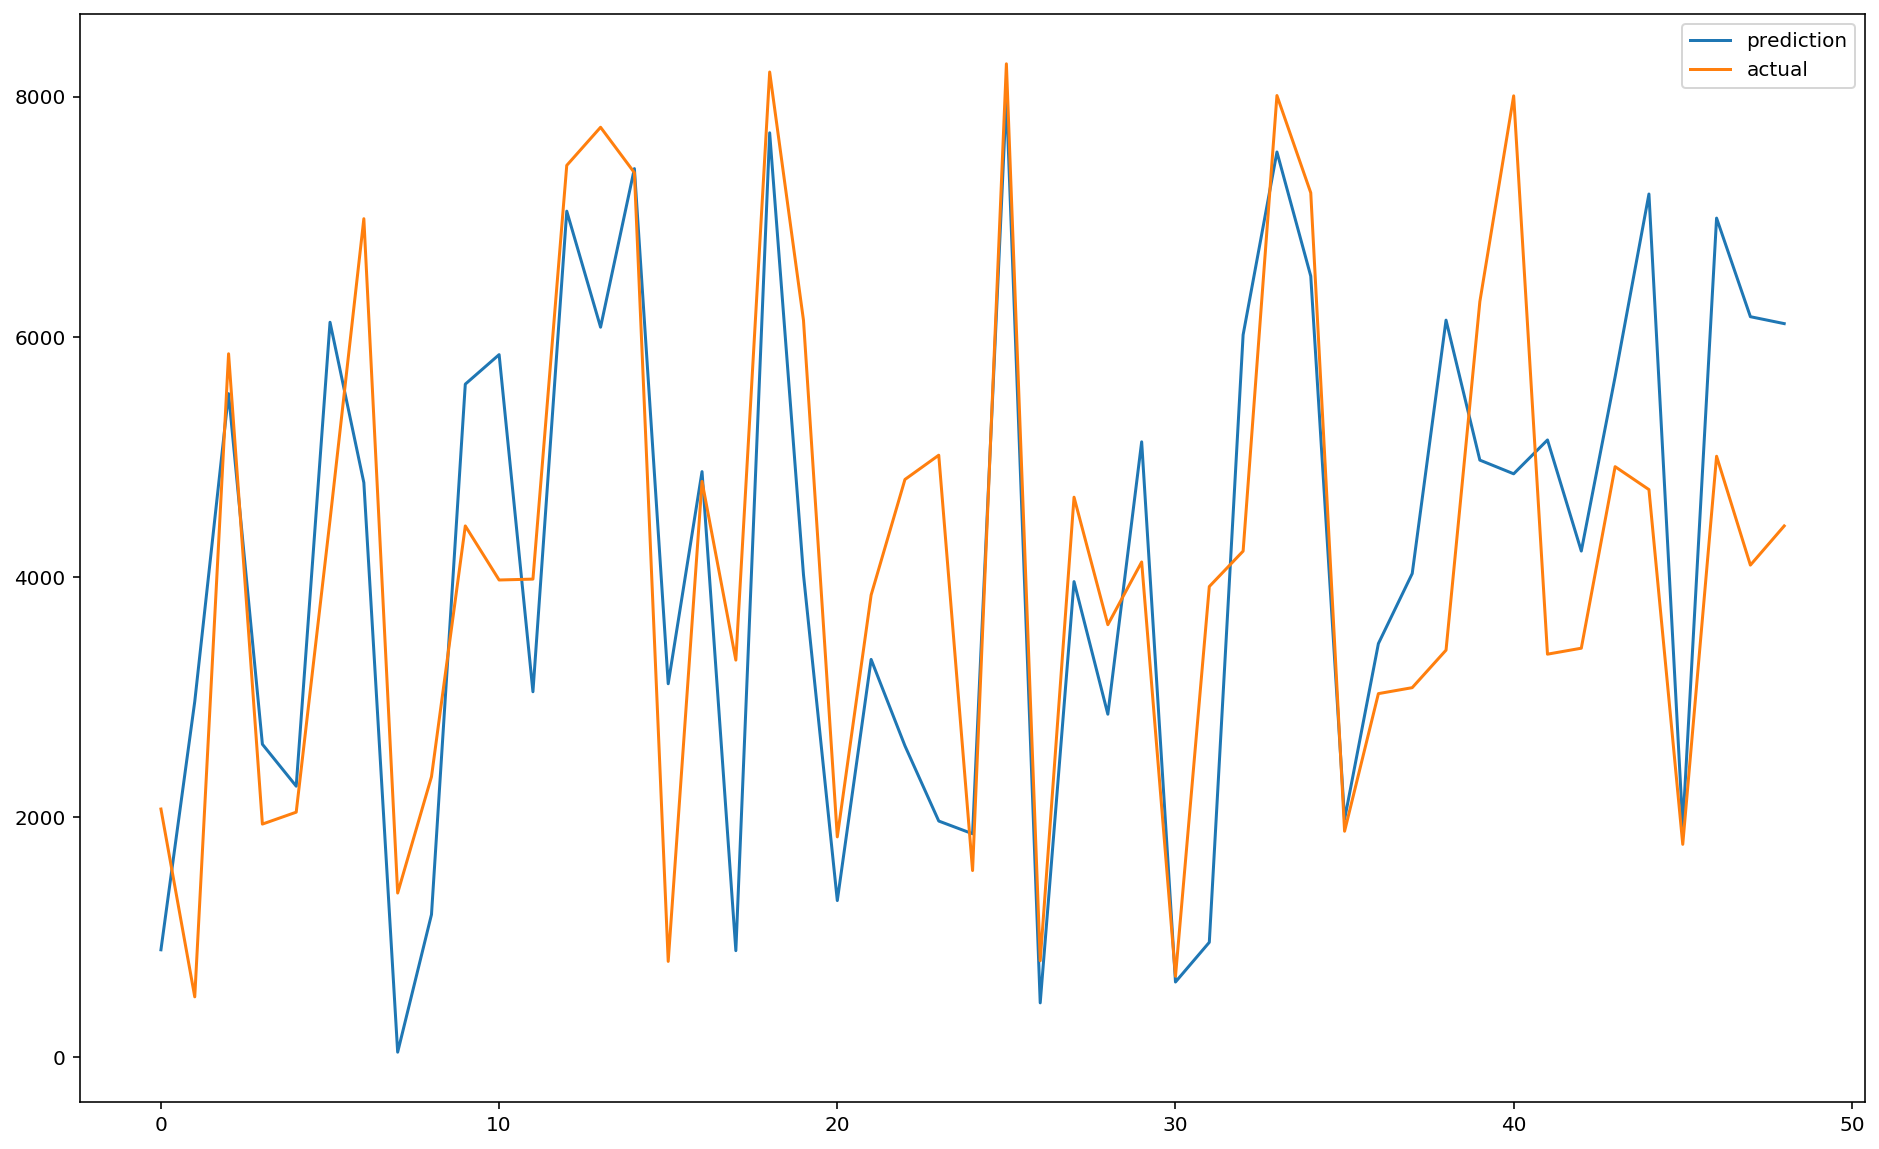

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,10
plt.plot(predict[1:50].T,label='prediction')
plt.plot(vaild_target[1:50]*val_std+vail_mean, label='actual')
plt.legend()

In [ ]:
train_loss_less = train_loss[1:]

In [ ]:
val_loss_less = val_loss[1:]

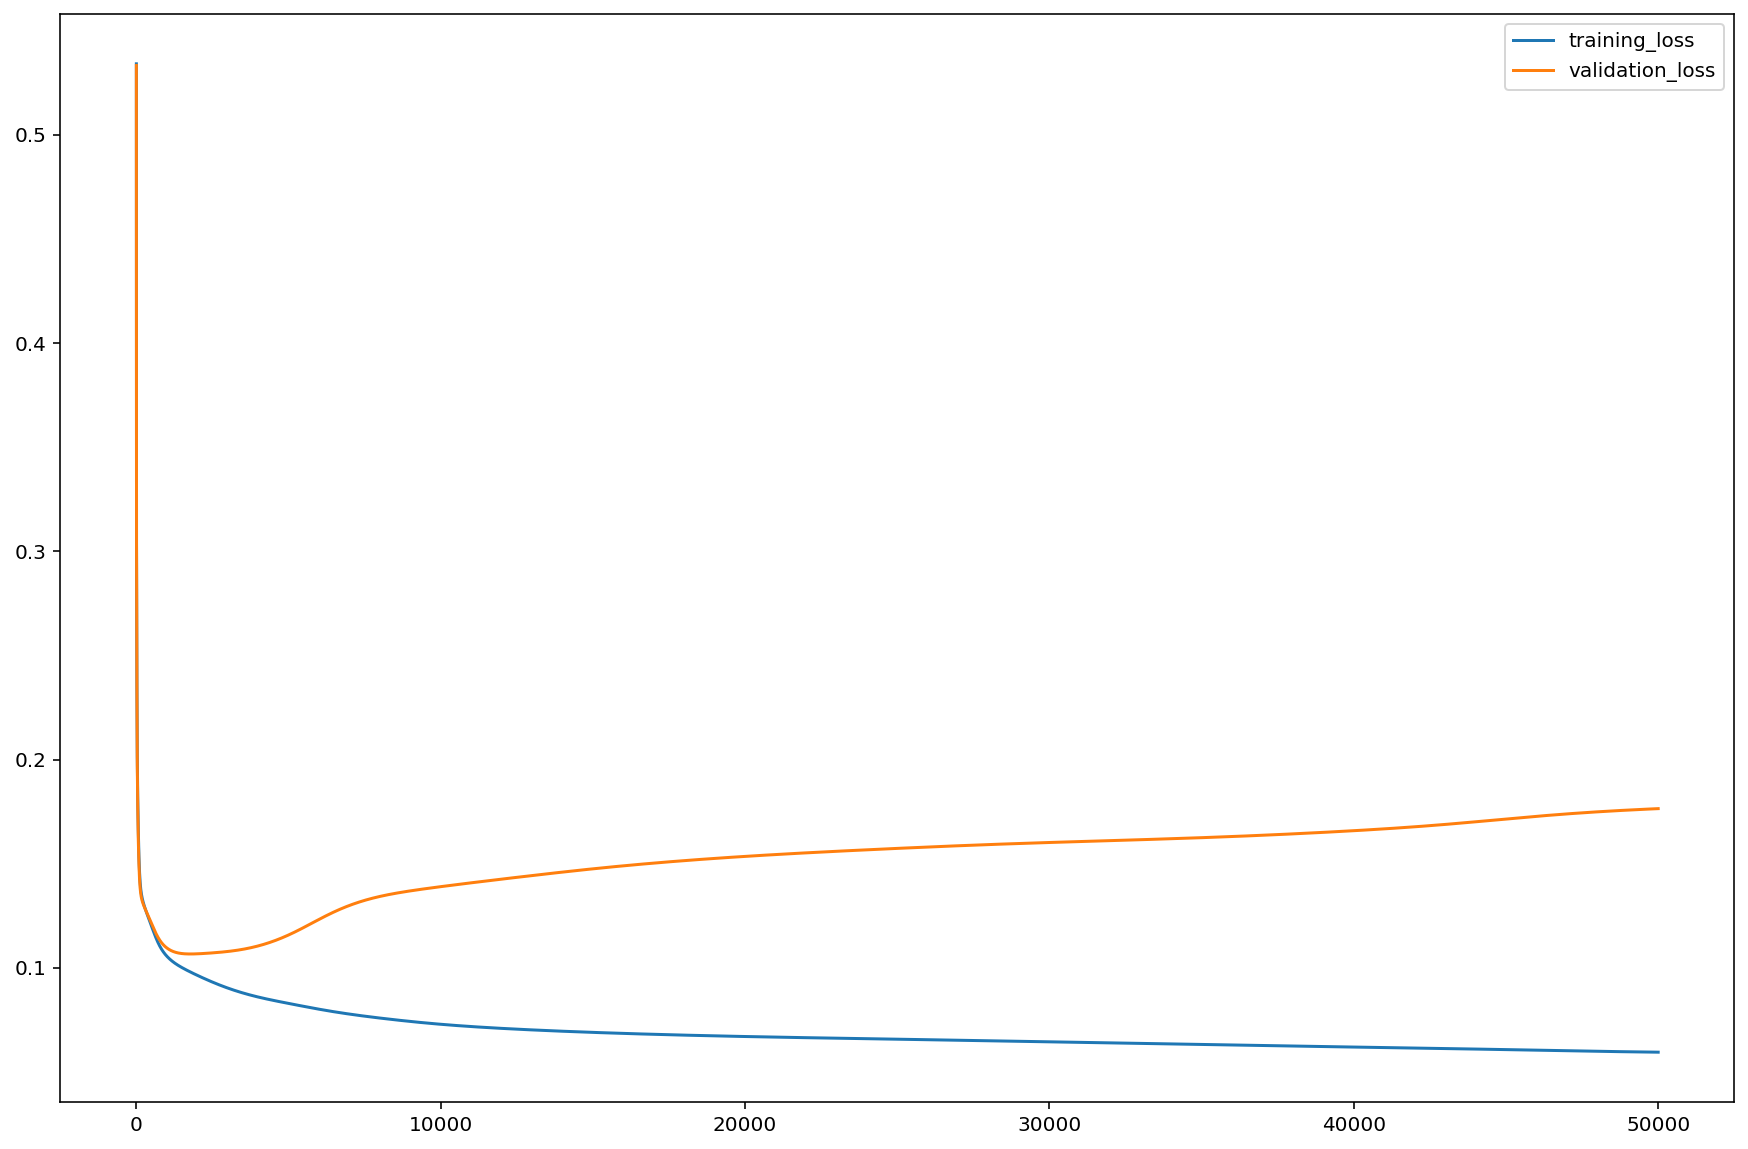

In [ ]:
rcParams['figure.figsize'] = 15,10
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_loss_less, label="training_loss")
ax1.plot(val_loss_less, label="validation_loss")
ax1.legend()